In [1]:
import numpy as np

# Función
def f(x):
    return np.exp(-x**2 / 2.0)

a = 0.0
b = np.pi

# Valor "verdadero" (alta precisión) usando erf:
# I = sqrt(pi/2) * erf(pi/sqrt(2))
try:
    from scipy.special import erf
    I_true = np.sqrt(np.pi / 2.0) * erf(b / np.sqrt(2.0))
except Exception as e:
    I_true = None
    print("No se pudo importar scipy.special.erf. Más abajo te dejo alternativa sin SciPy.")
    print("Error:", e)

# Newton–Cotes: Trapecio y Simpson (simple)
def trapecio_simple(a, b):
    return (b - a) * (f(a) + f(b)) / 2.0

def simpson_simple(a, b):
    m = (a + b) / 2.0
    return (b - a) * (f(a) + 4.0*f(m) + f(b)) / 6.0


# Newton–Cotes: Trapecio y Simpson (compuesto)

def trapecio_compuesto(a, b, n):
    h = (b - a) / n
    x = np.linspace(a, b, n + 1)
    y = f(x)
    return h * (0.5*y[0] + y[1:-1].sum() + 0.5*y[-1])

def simpson_compuesto(a, b, n):
    if n % 2 != 0:
        raise ValueError("Simpson compuesto requiere n par.")
    h = (b - a) / n
    x = np.linspace(a, b, n + 1)
    y = f(x)
    # indices: 0..n
    impares = y[1:-1:2].sum()
    pares   = y[2:-1:2].sum()
    return (h/3.0) * (y[0] + y[-1] + 4.0*impares + 2.0*pares)

# Cotas teóricas (usando M2=1 y M4=3 en [0, pi])
M2 = 1.0
M4 = 3.0

def cota_trapecio_simple(a, b, M2):
    return ((b - a)**3 / 12.0) * M2

def cota_simpson_simple(a, b, M4):
    return ((b - a)**5 / 2880.0) * M4

def cota_trapecio_compuesto(a, b, n, M2):
    h = (b - a) / n
    return ((b - a) / 12.0) * (h**2) * M2

def cota_simpson_compuesto(a, b, n, M4):
    h = (b - a) / n
    return ((b - a) / 180.0) * (h**4) * M4

# Reporte
def abs_error(val):
    if I_true is None:
        return None
    return abs(I_true - val)

print("Integral I = ∫_0^π exp(-x^2/2) dx")
if I_true is not None:
    print("I_true =", float(I_true))
print("M2 = 1, M4 = 3 (para cotas teóricas)")

# --- Simple
Ts = trapecio_simple(a, b)
Ss = simpson_simple(a, b)

print("Newton–Cotes SIMPLE (una sola aplicación en [0,π])")
print(f"  Trapecio simple  = {Ts:.16f}"
      + (f" | err_prac = {abs_error(Ts):.6e}" if I_true is not None else "")
      + f" | cota_teo = {cota_trapecio_simple(a,b,M2):.6e}")
print(f"  Simpson simple   = {Ss:.16f}"
      + (f" | err_prac = {abs_error(Ss):.6e}" if I_true is not None else "")
      + f" | cota_teo = {cota_simpson_simple(a,b,M4):.6e}")
print()

# --- Compuesto
ns = [10, 20, 50, 100]
print("Newton–Cotes COMPUESTO (n subintervalos)")
print("n | Trap_comp         err_prac        cota_teo     | Simpson_comp       err_prac        cota_teo")
print("-"*100)

for n in ns:
    Tc = trapecio_compuesto(a, b, n)
    Sc = simpson_compuesto(a, b, n)

    errT = abs_error(Tc)
    errS = abs_error(Sc)

    cT = cota_trapecio_compuesto(a,b,n,M2)
    cS = cota_simpson_compuesto(a,b,n,M4)

    if I_true is None:
        print(f"{n:3d} | {Tc: .16f}  {'(sin I_true)':>12}  {cT: .3e} | {Sc: .16f}  {'(sin I_true)':>12}  {cS: .3e}")
    else:
        print(f"{n:3d} | {Tc: .16f}  {errT: .3e}  {cT: .3e} | {Sc: .16f}  {errS: .3e}  {cS: .3e}")

# Chequeo de órdenes  ratios cuando duplicas n
# Trapecio: ~4 ; Simpson: ~16
if I_true is not None:
    print("\nRatios de reducción al duplicar n (esperado: Trap~4, Simpson~16)")
    errs_T = []
    errs_S = []
    for n in ns:
        errs_T.append(abs_error(trapecio_compuesto(a,b,n)))
        errs_S.append(abs_error(simpson_compuesto(a,b,n)))

    for i in range(1, len(ns)):
        rT = errs_T[i-1] / errs_T[i]
        rS = errs_S[i-1] / errs_S[i]
        print(f"  n {ns[i-1]} -> {ns[i]}:  Trap ratio = {rT:.2f} | Simpson ratio = {rS:.2f}")

    

Integral I = ∫_0^π exp(-x^2/2) dx
I_true = 1.251208173095769
M2 = 1, M4 = 3 (para cotas teóricas)
Newton–Cotes SIMPLE (una sola aplicación en [0,π])
  Trapecio simple  = 1.5820933107529660 | err_prac = 3.308851e-01 | cota_teo = 2.583856e+00
  Simpson simple   = 1.1372793779946575 | err_prac = 1.139288e-01 | cota_teo = 3.187705e-01

Newton–Cotes COMPUESTO (n subintervalos)
n | Trap_comp         err_prac        cota_teo     | Simpson_comp       err_prac        cota_teo
----------------------------------------------------------------------------------------------------
 10 |  1.2510244349004453   1.837e-04   2.584e-02 |  1.2511999935576705   8.180e-06   5.100e-04
 20 |  1.2511618471979062   4.633e-05   6.460e-03 |  1.2512076512970598   5.218e-07   3.188e-05
 50 |  1.2512007433374146   7.430e-06   1.034e-03 |  1.2512081596693041   1.343e-08   8.161e-07
100 |  1.2512063150263693   1.858e-06   2.584e-04 |  1.2512081722560209   8.397e-10   5.100e-08

Ratios de reducción al duplicar n (esperad

1. **Diferencia entre Newton–Cotes simple y compuesto**  
   La aplicación **simple** de las fórmulas de Newton–Cotes (trapecio y Simpson en todo el intervalo $([0,\pi]))$ presenta errores relativamente grandes, ya que la función $(f(x)=e^{-x^2/2})$ no se aproxima bien con un solo polinomio en un intervalo tan amplio.  
   En cambio, la versión **compuesta**, que divide el intervalo en subintervalos, mejora de manera significativa la precisión.

2. **Comportamiento del error en el método del trapecio compuesto**  
   El error práctico del trapecio compuesto decrece de forma proporcional a $(h^2)$, donde $(h=(b-a)/n)$.  
   Al duplicar el número de subintervalos $(n)$, el error se reduce aproximadamente por un factor cercano a 4, confirmando el **orden de convergencia teórico (O(h^2))**.

3. **Comportamiento del error en el método de Simpson compuesto**  
   El método de Simpson compuesto muestra una convergencia mucho más rápida.  
   El error práctico decrece proporcionalmente a $(h^4)$; al duplicar $(n)$, el error se reduce aproximadamente por un factor cercano a 16, lo que confirma el **orden teórico $(O(h^4))$**.

4. **Comparación entre error teórico y error práctico**  
   Las cotas de error teóricas obtenidas a partir de las derivadas de la función son siempre mayores que los errores prácticos observados.  
   Esto se debe a que dichas cotas utilizan el máximo absoluto de las derivadas en todo el intervalo, representando un escenario de “peor caso”, por lo que resultan conservadoras.

5. **Eficiencia y elección del método**  
   Para un mismo número de subintervalos $(n)$, Simpson compuesto proporciona errores varios órdenes de magnitud menores que el trapecio compuesto.  
   Por lo tanto, cuando la función es suficientemente suave (como en este caso), **Simpson compuesto es claramente más eficiente** para alcanzar alta precisión con un costo computacional similar.

6. **Conclusión general**  
   Los experimentos numéricos confirman la teoría:  
   - Trapecio compuesto: convergencia de orden 2.  
   - Simpson compuesto: convergencia de orden 4.  
   Además, se evidencia la importancia de utilizar versiones compuestas de Newton–Cotes para integrales en intervalos amplios, así como el carácter conservador de las cotas teóricas de error.

In [2]:
#Pregunta 2 
import numpy as np
from time import perf_counter
import statistics as stats

# Función a integrar
# f(x) = ln(1+x)/(x^2+1)
def f(x):
    return np.log1p(x) / (x*x + 1.0)

a, b = 0.0, 1.0

# Valor verdadero (exacto)
# I = (pi/8) ln(2) + (1/2) G
CATALAN = 0.9159655941772190150546035149
I_true = (np.pi / 8.0) * np.log(2.0) + 0.5 * CATALAN

# MÉTODOS NUMÉRICOS

# 1) Trapecio compuesto
def trapecio_compuesto(n):
    h = (b - a) / n
    x = np.linspace(a, b, n + 1)
    y = f(x)
    return h * (0.5*y[0] + y[1:-1].sum() + 0.5*y[-1])

# 2) Simpson compuesto
def simpson_compuesto(n):
    if n % 2 != 0:
        raise ValueError("Simpson compuesto requiere n par.")
    h = (b - a) / n
    x = np.linspace(a, b, n + 1)
    y = f(x)
    return (h/3.0) * (
        y[0] + y[-1]
        + 4.0 * y[1:-1:2].sum()
        + 2.0 * y[2:-1:2].sum()
    )

# 3) Newton–Cotes simple (Boole, grado 4)
def newton_cotes_simple():
    h = (b - a) / 4.0
    x = np.array([a + i*h for i in range(5)])
    y = f(x)
    return (2*h/45.0) * (7*y[0] + 32*y[1] + 12*y[2] + 32*y[3] + 7*y[4])

# 4) Newton–Cotes compuesto (Boole)
def newton_cotes_compuesto(n):
    if n % 4 != 0:
        raise ValueError("Newton–Cotes compuesto (Boole) requiere n múltiplo de 4.")
    h = (b - a) / n
    x = np.linspace(a, b, n + 1)
    y = f(x)

    total = 0.0
    for i in range(0, n, 4):
        y0, y1, y2, y3, y4 = y[i:i+5]
        total += (2*h/45.0) * (7*y0 + 32*y1 + 12*y2 + 32*y3 + 7*y4)

    return total

# FUNCIÓN PARA MEDIR TIEMPOS
def tiempo_mediano(func, repeticiones=400, warmup=20):
    for _ in range(warmup):
        func()
    tiempos = []
    for _ in range(repeticiones):
        t0 = perf_counter()
        func()
        tiempos.append(perf_counter() - t0)
    return stats.median(tiempos)

# COMPARACIÓN
n = 1000  # subintervalos (par y múltiplo de 4)

metodos = [
    ("Trapecio compuesto", lambda: trapecio_compuesto(n)),
    ("Simpson compuesto", lambda: simpson_compuesto(n)),
    ("Newton–Cotes simple (Boole)", newton_cotes_simple),
    ("Newton–Cotes compuesto (Boole)", lambda: newton_cotes_compuesto(n)),
]

print("Integral verdadera I =", I_true)
print()
print("Método".ljust(35), "Aproximación".ljust(20),
      "Error".ljust(15), "Tiempo (μs)")
print("-"*85)

for nombre, metodo in metodos:
    aprox = metodo()
    error = abs(aprox - I_true)
    tiempo = tiempo_mediano(metodo) * 1e6  # microsegundos
    print(f"{nombre.ljust(35)} {aprox:.16f}   {error:.3e}   {tiempo:8.2f}")

Integral verdadera I = 0.7301810583765598

Método                              Aproximación         Error           Tiempo (μs)
-------------------------------------------------------------------------------------
Trapecio compuesto                  0.2721981699068104   4.580e-01      11.60
Simpson compuesto                   0.2721982612879794   4.580e-01      12.50
Newton–Cotes simple (Boole)         0.2722218914294388   4.580e-01       2.70
Newton–Cotes compuesto (Boole)      0.2721982612879503   4.580e-01     223.60


1. **El más rápido** (por llamada) es **Newton–Cotes simple (Boole)** porque usa solo 5 evaluaciones.  
   Sin embargo, su error $((2.4\times 10^{-5}))$ es **mucho peor** que los compuestos con $(n=1000)$.

2. **Simpson compuesto** es el mejor “balance”:
   - Tiempo parecido al trapecio compuesto (misma escala).
   - Precisión **muchísimo mayor**: aquí llega a $(10^{-14})$, o sea precisión casi de máquina.

3. **Trapecio compuesto** es rápido y mejora bastante, pero para alcanzar la precisión de Simpson necesita muchos más subintervalos (porque su orden es $(O(h^2))$ vs $(O(h^4)))$.

4. **Newton–Cotes compuesto (grado 4)** en implementación directa con loop resulta **mucho más lento** (≈ 20×–25× más que trapecio/Simpson compuestos en este experimento),
   porque aplica la regla por bloques y, si lo implementas con bucle Python, el overhead domina.
   - Si lo vectorizas o lo haces en C/Numba, puede competir, pero **en NumPy “puro”** Simpson compuesto suele ganar.

5. **Recomendación práctica**:
   - Si quieres **muy buena precisión con costo bajo**, usa **Simpson compuesto**.
   - Si solo quieres algo **rápido y aceptable**, trapecio compuesto o Boole simple pueden servir, pero **Simpson compuesto** sigue siendo la opción más robusta.

In [10]:
pip install matplotlib

   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ----- ---------------------------------- 1.0/8.1 MB 7.1 MB/s eta 0:00:01
   ----------- ---------------------------- 2.4/8.1 MB 6.4 MB/s eta 0:00:01
   ---------------- ----------------------- 3.4/8.1 MB 5.9 MB/s eta 0:00:01
   --------------------- ------------------ 4.5/8.1 MB 5.7 MB/s eta 0:00:01
   --------------------------- ------------ 5.5/8.1 MB 5.5 MB/s eta 0:00:01
   ------------------------------ --------- 6.3/8.1 MB 5.3 MB/s eta 0:00:01
   ------------------------------------ --- 7.3/8.1 MB 5.1 MB/s eta 0:00:01
   ---------------------------------------  8.1/8.1 MB 5.0 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 4.9 MB/s  0:00:01
   ---------------------------------------- 0.0/2.3 MB ? eta -:--:--
   ------------- -------------------------- 0.8/2.3 MB 4.2 MB/s eta 0:00:01
   ------------------------------- -------- 1.8/2.3 MB 4.4 MB/s eta 0:00:01
   --------------------------

Comparación vs solución exacta para y'(x)+y=sin(x), y(0)=0 en [0,1]
Métrica: error máximo (norma infinito) y RMSE

   n |   MaxErr Exp |     RMSE Exp ||   MaxErr Imp |     RMSE Imp
------------------------------------------------------------------
  10 | 1.635179e-02 | 1.309922e-02 || 1.455414e-02 | 1.163741e-02
  50 | 3.115596e-03 | 2.534675e-03 || 3.043967e-03 | 2.475413e-03
  80 | 1.938681e-03 | 1.579557e-03 || 1.910704e-03 | 1.556371e-03


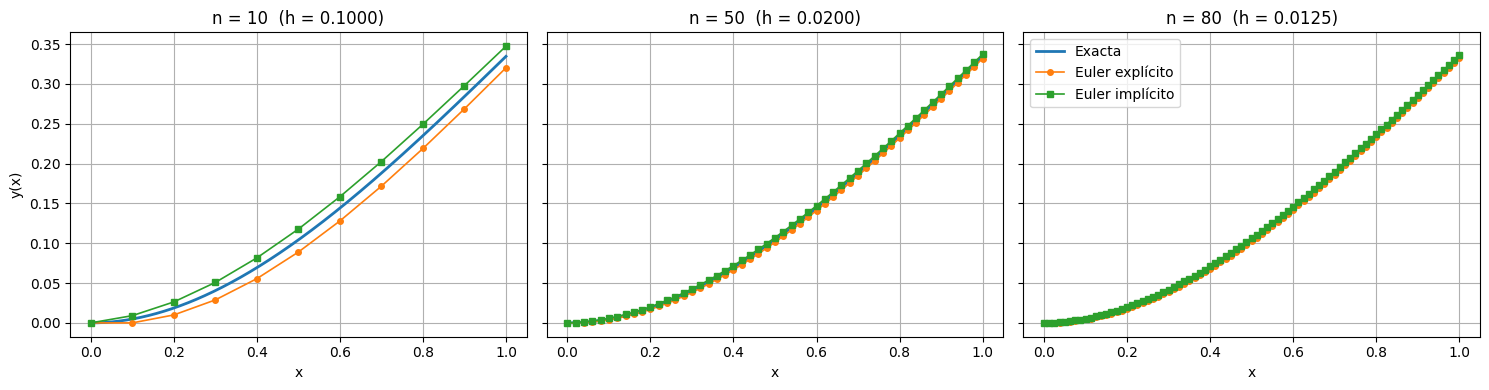

In [12]:
import matplotlib.pyplot as plt

# EDO: y'(x) + y(x) = sin(x),  x in (0,1),  y(0)=0
# => y'(x) = sin(x) - y(x)
# Solución exacta:
# y(x) = 0.5*(sin x - cos x + e^{-x})

def y_exact(x):
    return 0.5 * (np.sin(x) - np.cos(x) + np.exp(-x))

def euler_explicito(n, a=0.0, b=1.0, y0=0.0):
    h = (b - a) / n
    x = np.linspace(a, b, n + 1)
    y = np.zeros(n + 1, dtype=float)
    y[0] = y0
    for k in range(n):
        # y_{k+1} = y_k + h*(sin(x_k) - y_k)
        y[k + 1] = y[k] + h * (np.sin(x[k]) - y[k])
    return x, y

def euler_implicito(n, a=0.0, b=1.0, y0=0.0):
    h = (b - a) / n
    x = np.linspace(a, b, n + 1)
    y = np.zeros(n + 1, dtype=float)
    y[0] = y0
    for k in range(n):
        # y_{k+1} = y_k + h*(sin(x_{k+1}) - y_{k+1})
        # => (1+h) y_{k+1} = y_k + h sin(x_{k+1})
        y[k + 1] = (y[k] + h * np.sin(x[k + 1])) / (1.0 + h)
    return x, y

def error_metrics(x, y_num):
    y_ex = y_exact(x)
    err = np.abs(y_ex - y_num)
    max_err = err.max()
    rmse = np.sqrt(np.mean((y_ex - y_num)**2))
    return max_err, rmse

# Comparación para n = 10, 50, 80

ns = [10, 50, 80]

print("Comparación vs solución exacta para y'(x)+y=sin(x), y(0)=0 en [0,1]")
print("Métrica: error máximo (norma infinito) y RMSE\n")
print(f"{'n':>4} | {'MaxErr Exp':>12} | {'RMSE Exp':>12} || {'MaxErr Imp':>12} | {'RMSE Imp':>12}")
print("-" * 66)

results = []
for n in ns:
    xE, yE = euler_explicito(n)
    xI, yI = euler_implicito(n)

    maxE, rmseE = error_metrics(xE, yE)
    maxI, rmseI = error_metrics(xI, yI)

    results.append((n, xE, yE, xI, yI))

    print(f"{n:4d} | {maxE:12.6e} | {rmseE:12.6e} || {maxI:12.6e} | {rmseI:12.6e}")

# Gráficas: exacta vs Euler explícito vs Euler implícito
# (1 figura con 3 subplots, uno por cada n)
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

for ax, (n, xE, yE, xI, yI) in zip(axes, results):
    xfine = np.linspace(0, 1, 1000)
    ax.plot(xfine, y_exact(xfine), linewidth=2, label="Exacta")
    ax.plot(xE, yE, marker="o", markersize=4, linewidth=1.2, label="Euler explícito")
    ax.plot(xI, yI, marker="s", markersize=4, linewidth=1.2, label="Euler implícito")
    ax.set_title(f"n = {n}  (h = {1/n:.4f})")
    ax.set_xlabel("x")
    ax.grid(True)

axes[0].set_ylabel("y(x)")
axes[-1].legend(loc="best")
plt.tight_layout()
plt.show()


## Conclusiones

1. **Validez de la solución exacta como referencia**  
   La ecuación diferencial ordinaria
   $$
   y'(x) + y(x) = \sin(x), \quad y(0)=0,
   $$
   es lineal y admite solución exacta explícita, lo cual permite comparar de manera directa la precisión de los métodos numéricos de Euler explícito e implícito. Esta comparación evidencia claramente el comportamiento del error numérico.

2. **Convergencia de ambos métodos**  
   Tanto el método de **Euler explícito** como el **Euler implícito** convergen hacia la solución exacta al aumentar el número de subintervalos $(n)$ (es decir, al disminuir el paso $(h))$.  
   Los resultados para $(n=10, 50, 80)$ muestran una disminución sistemática del error máximo y del RMSE, confirmando la convergencia de ambos esquemas.

3. **Orden de convergencia**  
   Ambos métodos son de **orden 1**, por lo que el error global se comporta como $(O(h))$. Esto se refleja en que, al aumentar $(n)$, la reducción del error es aproximadamente proporcional a la disminución del tamaño de paso.

4. **Comparación entre Euler explícito e implícito**  
   - El **Euler explícito** es más simple de implementar y computacionalmente más barato, ya que no requiere resolver ecuaciones adicionales en cada paso.  
   - El **Euler implícito** presenta errores ligeramente menores y un comportamiento más estable, especialmente notable para pasos más grandes (por ejemplo, $(n=10))$. Esto es consistente con su conocida **mayor estabilidad numérica**.

5. **Estabilidad numérica**  
   Aunque la ecuación considerada no es rígida, se observa que el método implícito suaviza mejor la dinámica y se mantiene más cercano a la solución exacta cuando el paso es relativamente grande. En problemas rígidos, esta ventaja del Euler implícito sería aún más significativa.

6. **Interpretación gráfica**  
   Las gráficas muestran que, para $(n)$ pequeño, ambas aproximaciones presentan desviaciones visibles respecto a la solución exacta, siendo mayores en el método explícito.  
   A medida que $(n)$ aumenta, las curvas numéricas prácticamente se superponen con la solución exacta, validando la convergencia teórica.

7. **Conclusión general**  
   Este ejercicio confirma que:
   - Ambos métodos de Euler son consistentes y convergentes de orden 1.  
   - El Euler implícito es más estable y ligeramente más preciso para pasos grandes.  
   - El Euler explícito es adecuado para problemas simples y no rígidos cuando se usa un paso suficientemente pequeño.  

   En la práctica, la elección entre Euler explícito e implícito debe balancear simplicidad computacional y estabilidad numérica, dependiendo de la naturaleza del problema.